<a href="https://colab.research.google.com/github/imdeepmind/BrandLogoDetection/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

## Constants

In [0]:
BATCH_SIZE = 128
EPOCHS=30

## Preparing the data

In [2]:
!pip install torch torchvision matplotlib

from google.colab import drive
drive.mount('/content/drive')

!mkdir datasets
!mkdir datasets/processed

!cp 'drive/My Drive/dataset/brandLogo/brandLogo.zip' .

!unzip -qq brandLogo.zip -d 'datasets/processed'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
# Data Transforms
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
# Reading the dataset from the folders
training_data = datasets.ImageFolder('datasets/processed/train', transform=transform_train)
validation_data = datasets.ImageFolder('datasets/processed/validation', transform=transform_test)
testing_data = datasets.ImageFolder('datasets/processed/test', transform=transform_test)

In [0]:
# Initializing the data loaders
training = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
testing = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)

## The Model

In [0]:
from torchvision import models
import torch.nn as nn
import torch

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running the model in ', device.type)

Running the model in  cuda


In [0]:
model = models.mobilenet_v2(pretrained=True)

In [0]:
for param in model.features.parameters():
    param.requires_grad = False

In [25]:
n_inputs = model.classifier[1].in_features
last_layer = nn.Linear(n_inputs, 32)
model.classifier[1] = last_layer
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

## Training the model

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [0]:
training_losses = []
validation_losses = []

training_accuracy = []
validation_accuracy = []

In [28]:
for i in range(0, EPOCHS):
    training_epoch_loss = 0.0
    validation_epoch_loss = 0.0

    training_epoch_correct = 0
    validation_epoch_correct = 0

    for inputs, labels in training:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        training_epoch_loss += loss.item()
        training_epoch_correct += torch.sum(preds == labels.data).cpu().numpy()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            validation_epoch_loss += loss.item()
            validation_epoch_correct += torch.sum(preds == labels.data).cpu().numpy()
    
    training_average_loss = training_epoch_loss/len(training.dataset)
    training_epoch_accuracy = (training_epoch_correct/len(training.dataset))*100

    validation_average_loss = validation_epoch_loss/len(validation.dataset)
    validation_epoch_accuracy = (validation_epoch_correct/len(validation.dataset))*100
    
    training_losses.append(training_average_loss)
    training_accuracy.append(training_epoch_accuracy)

    validation_losses.append(validation_average_loss)
    validation_accuracy.append(validation_epoch_accuracy)

    print("EPOCH: {} Training Loss: {} Training Accuracy: {} Validation Loss: {} Validation Accuracy: {}".format(i+1, training_average_loss, training_epoch_accuracy, validation_average_loss, validation_epoch_accuracy))

EPOCH: 1 Training Loss: 0.08441100707720291 Training Accuracy: 26.452232357177145 Validation Loss: 0.06083211761853091 Validation Accuracy: 46.47519582245431
EPOCH: 2 Training Loss: 0.06659312152084226 Training Accuracy: 41.09457513202112 Validation Loss: 0.054506068285700544 Validation Accuracy: 50.65274151436031
EPOCH: 3 Training Loss: 0.06105637569430542 Training Accuracy: 45.97535605696911 Validation Loss: 0.0510573170826267 Validation Accuracy: 56.39686684073107
EPOCH: 4 Training Loss: 0.05871619362128336 Training Accuracy: 47.70363258121299 Validation Loss: 0.04941803995062726 Validation Accuracy: 55.35248041775457
EPOCH: 5 Training Loss: 0.05725952123027551 Training Accuracy: 49.079852776444234 Validation Loss: 0.049854286501364045 Validation Accuracy: 55.87467362924282
EPOCH: 6 Training Loss: 0.05699316259955841 Training Accuracy: 49.863978236517845 Validation Loss: 0.048919589650226324 Validation Accuracy: 56.26631853785901
EPOCH: 7 Training Loss: 0.05534388944995482 Training 

In [0]:
import matplotlib.pyplot as plt

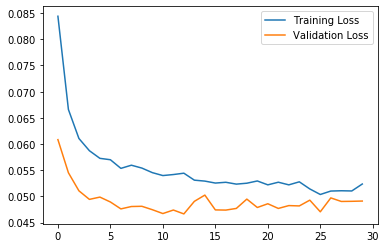

In [30]:
plt.plot(range(0, len(training_losses)), training_losses, label="Training Loss")
plt.plot(range(0, len(validation_losses)), validation_losses, label="Validation Loss")
plt.legend()

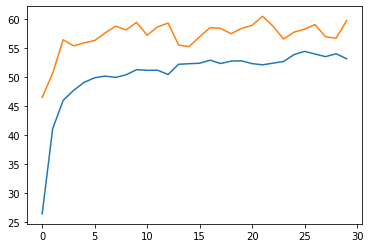

In [31]:
plt.plot(range(0, len(training_accuracy)), training_accuracy, label="Training Accuracy")
plt.plot(range(0, len(validation_accuracy)), validation_accuracy, label="Validation Accuracy")